In [1]:
#akcje an gpu

In [2]:
import pandas as pd
import yfinance as yf

# 📌 Ustawienia
ticker = "AAPL"
start_date = "2010-01-01"
end_date = "2024-03-31"
csv_filename = "AAPL_stock_data.csv"

# 📊 Pobieranie danych giełdowych
print(f"📥 Pobieranie danych dla {ticker} od {start_date} do {end_date}...")
df = yf.download(ticker, start=start_date, end=end_date)

# 🔄 Reset indeksu (data stanie się kolumną)
df.reset_index(inplace=True)

# 📝 Zapis do pliku CSV
df.to_csv(csv_filename, index=False)
print(f"✅ Dane zapisane do {csv_filename}")

# 📂 Wczytywanie danych z pliku CSV
print(f"📥 Wczytywanie danych z pliku {csv_filename}...")
df = pd.read_csv(csv_filename, parse_dates=["Date"])

# 🔄 Ustawienie indeksu na datę
df.set_index("Date", inplace=True)

# 📌 **Sortowanie indeksu, aby uniknąć błędu z KeyError**
df.sort_index(inplace=True)

# 🛠 Sprawdzenie zakresu dostępnych dat w indeksie
print(f"📊 Zakres dat: {df.index.min()} → {df.index.max()}")

# 🟢 **Lepsza metoda podziału na zbiór treningowy i testowy**
df_train = df[df.index < "2024-01-01"]
df_test = df[df.index >= "2024-01-01"]

# 📊 Podsumowanie danych
print(f"📊 Dane treningowe: {df_train.shape}")
print(f"📊 Dane testowe: {df_test.shape}")

# 📈 Podgląd pierwszych wierszy
print("\n🔹 Przykładowe dane treningowe:")
print(df_train.head())

print("\n🔹 Przykładowe dane testowe:")
print(df_test.head())


📥 Pobieranie danych dla AAPL od 2010-01-01 do 2024-03-31...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

✅ Dane zapisane do AAPL_stock_data.csv
📥 Wczytywanie danych z pliku AAPL_stock_data.csv...
📊 Zakres dat: 2010-01-04 00:00:00 → 2024-03-28 00:00:00
📊 Dane treningowe: (3522, 5)
📊 Dane testowe: (61, 5)

🔹 Przykładowe dane treningowe:
                        Close                High                Low  \
Date                                                                   
2010-01-04  6.440330505371094  6.4550763032980685  6.391278025967366   
2010-01-05  6.451466083526611   6.487879368872802  6.417459939457402   
2010-01-06   6.34884786605835     6.4770467400542  6.342227121682705   
2010-01-07  6.337110996246338  6.3798444920330555  6.291067931697854   
2010-01-08  6.379241943359375   6.379844231009115  6.291369420820416   

                          Open     Volume  
Date                                       
2010-01-04  6.4228762217812925  493729600  
2010-01-05   6.458086826968792  601904800  
2010-01-06    6.45146699312308  552160000  
2010-01-07   6.372320918515503  477131200  

Epoch [10/55], Loss: 0.0787
Epoch [20/55], Loss: 0.0701
Epoch [30/55], Loss: 0.0517
Epoch [40/55], Loss: 0.0048
Epoch [50/55], Loss: 0.0047
✅ Trening zakończony!
📁 Model zapisany jako lstm_stock_model.pth
📊 RMSE modelu: 5.7598


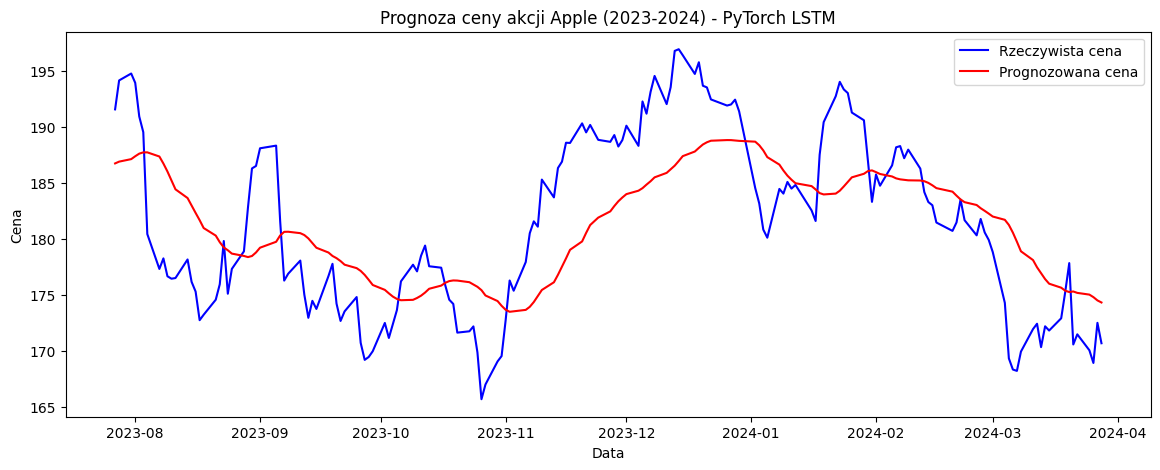

📌 Model został wczytany poprawnie!


In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 📌 Wczytanie danych
file_path = "AAPL_stock_data.csv"
df = pd.read_csv(file_path, skiprows=1)

# Poprawienie nazw kolumn
df.columns = ["Date", "Close", "High", "Low", "Open", "Volume"]

# Konwersja do poprawnych typów
df["Date"] = pd.to_datetime(df["Date"], errors='coerce')
df = df.dropna(subset=["Date"])
df.set_index("Date", inplace=True)

numeric_columns = ["Close", "High", "Low", "Open", "Volume"]
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# 📆 Podział danych na treningowe (do maja 2023) i testowe (od maja 2023)
train_data = df.loc[:'2023-05-01', 'Close'].values.reshape(-1, 1)
test_data = df.loc['2023-05-01':, 'Close'].values.reshape(-1, 1)

# 🔄 Normalizacja danych
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

# 🔄 Tworzenie sekwencji dla LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60  # 60 dni do przewidywania

X_train, y_train = create_sequences(scaled_train_data, seq_length)
X_test, y_test = create_sequences(scaled_test_data, seq_length)

# 🎛️ Konwersja do tensora PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = torch.tensor(X_train, dtype=torch.float32).view(-1, seq_length, 1).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)

X_test = torch.tensor(X_test, dtype=torch.float32).view(-1, seq_length, 1).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

# 🏗️ Definicja modelu LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 50).to(device)
        c0 = torch.zeros(2, x.size(0), 50).to(device)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])

# 📌 Inicjalizacja modelu
model = LSTMModel().to(device)

# 🔧 Definicja funkcji kosztu i optymalizatora
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 🎓 Trenowanie modelu
num_epochs = 55
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("✅ Trening zakończony!")

# 💾 Zapis modelu
model_path = "lstm_stock_model.pth"
torch.save(model.state_dict(), model_path)
print(f"📁 Model zapisany jako {model_path}")

# 🧪 Prognoza na danych testowych
model.eval()
with torch.no_grad():
    predictions = model(X_test)

# Odwrócenie normalizacji
predictions = scaler.inverse_transform(predictions.cpu().numpy())
y_test_actual = scaler.inverse_transform(y_test.cpu().numpy())

# 📏 RMSE
rmse = np.sqrt(np.mean((predictions - y_test_actual) ** 2))
print(f'📊 RMSE modelu: {rmse:.4f}')

# 📈 Wizualizacja wyników
plt.figure(figsize=(14,5))
plt.plot(df.loc['2023-05-01':].index[seq_length:], y_test_actual, color='blue', label='Rzeczywista cena')
plt.plot(df.loc['2023-05-01':].index[seq_length:], predictions, color='red', label='Prognozowana cena')
plt.title('Prognoza ceny akcji Apple (2023-2024) - PyTorch LSTM')
plt.xlabel('Data')
plt.ylabel('Cena')
plt.legend()
plt.show()

# 🔄 Wczytanie modelu (przykład)
loaded_model = LSTMModel().to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()
print("📌 Model został wczytany poprawnie!")

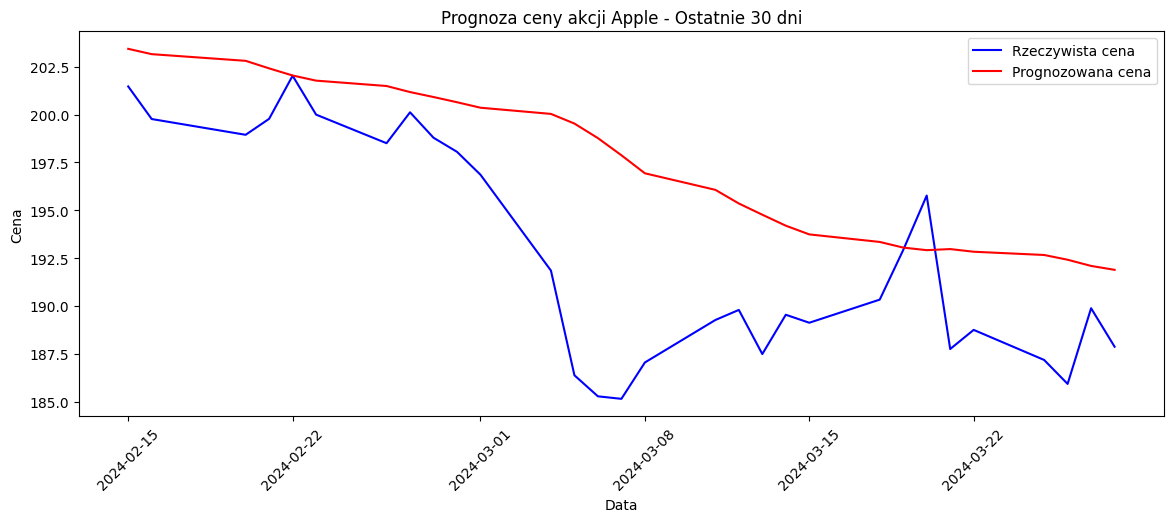

In [ ]:
# 📌 Wczytanie zapisanych wag modelu
loaded_model = LSTMModel().to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()

# 🧪 Prognoza na danych testowych
with torch.no_grad():
    predictions = loaded_model(X_test)

# Odwrócenie normalizacji wyników
predictions = scaler.inverse_transform(predictions.cpu().numpy())
y_test_actual = scaler.inverse_transform(y_test.cpu().numpy())

# 📆 Wybór okresu do wizualizacji (ostatnie 30 dni testowych)
num_days_to_show = 30  # np. miesiąc
test_dates = df.loc['2023-05-01':].index[seq_length:]

# Sprawdzenie, czy mamy wystarczającą ilość danych do wyświetlenia
if len(test_dates) >= num_days_to_show:
    test_dates = test_dates[-num_days_to_show:]
    predictions = predictions[-num_days_to_show:]
    y_test_actual = y_test_actual[-num_days_to_show:]

# 📈 Wizualizacja wyników dla wybranego okresu
plt.figure(figsize=(14,5))
plt.plot(test_dates, y_test_actual, color='blue', label='Rzeczywista cena')
plt.plot(test_dates, predictions, color='red', label='Prognozowana cena')
plt.title(f'Prognoza ceny akcji Apple - Ostatnie {num_days_to_show} dni')
plt.xlabel('Data')
plt.ylabel('Cena')
plt.legend()
plt.xticks(rotation=45)  # Obrót dat dla lepszej czytelności
plt.show()


In [ ]:
start_year = df.index.min().year
print(f"Dane zaczynają się od roku: {start_year}")

Dane zaczynają się od roku: 2010


In [ ]:
end_date = df.index.max()
print(f"Dane kończą się na dacie: {end_date}")

Dane kończą się na dacie: 2024-03-28 00:00:00
